In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.hh import Na, K, Leak, Na8States, K5States

import jaxley as jx
from jaxley import Compartment


In [2]:
# stimulus

# Duration and step size.
dt = 0.05  # ms

i_delay = 5.0  # ms
i_dur = 25.0  # ms
i_offset = .0
t_max = 50
current = jx.step_current(i_delay, i_dur, .002, dt, t_max, i_offset=i_offset)[:-1]

time_vec = jnp.arange(0, t_max, dt)


In [3]:
# original HH model
cell_hh = Compartment()

na_hh = Na(name="Na")
k_hh = K(name="K")
leak = Leak()

cell_hh.insert(na_hh)
cell_hh.insert(k_hh)
cell_hh.insert(leak)

params = {
    "Na_gNa": 120e-3,  # S/cm^2
    "Na_eNa": 50,  # mV

    "K_gK": 36e-3,  # S/cm^2
    "K_eK": -77,  # mV

    "Leak_gLeak": 0.3e-3,  # S/cm^2
    "Leak_eLeak": -54.3,  # mV

    "length": 5,
    "radius": 2.5,
    "v": -65.0,
}

for channel_name, channel_param in params.items():
    cell_hh.set(channel_name, channel_param)

cell_hh.init_states()


state_names = ["Na_m", "Na_h", "K_n", "i_Na", "i_K", "i_Leak", "v"]
for state_name in state_names:
    cell_hh.record(state_name, verbose=False)

cell_hh.stimulate(current, verbose=False)
s_hh = jx.integrate(cell_hh, delta_t=dt)

# transform s_hh into dict
s_hh_dict = {}
for i, state_name in enumerate(state_names):
    s_hh_dict[state_name] = s_hh[i].T[:-1]

# markov formulation of HH model
cell_mm = Compartment()

na_mm = Na8States(name="Na", solver="newton")
k_mm = K5States(name="K", solver="newton")
leak = Leak()

cell_mm.insert(na_mm)
cell_mm.insert(k_mm)
cell_mm.insert(leak)

for channel_name, channel_param in params.items():
    cell_mm.set(channel_name, channel_param)
cell_mm.init_states()



state_names = ["Na_C3", "Na_C2", "Na_C1", "Na_I3", "Na_I2", "Na_I1", "Na_I", "Na_O", 
               "K_C4", "K_C3", "K_C2", "K_C1", "K_O", "i_Na", "i_K", "i_Leak", "v"]
for state_name in state_names:
    cell_mm.record(state_name, verbose=False)

# run the model
cell_mm.stimulate(current, verbose=False)
s_mm = jx.integrate(cell_mm, delta_t=dt)

# transform s_mm into dict
s_mm_dict = {}
for i, state_name in enumerate(state_names):
    s_mm_dict[state_name] = s_mm[i].T[:-1]

gNa_mm = na_mm.channel_params["Na_gNa"] * s_mm[0].T[:-1] * 1000
gK_mm = k_mm.channel_params["K_gK"] * s_mm[1].T[:-1] * 1000

Text(0.5, 1.02, 'Hodgkin-Huxley model vs. Markov States model')

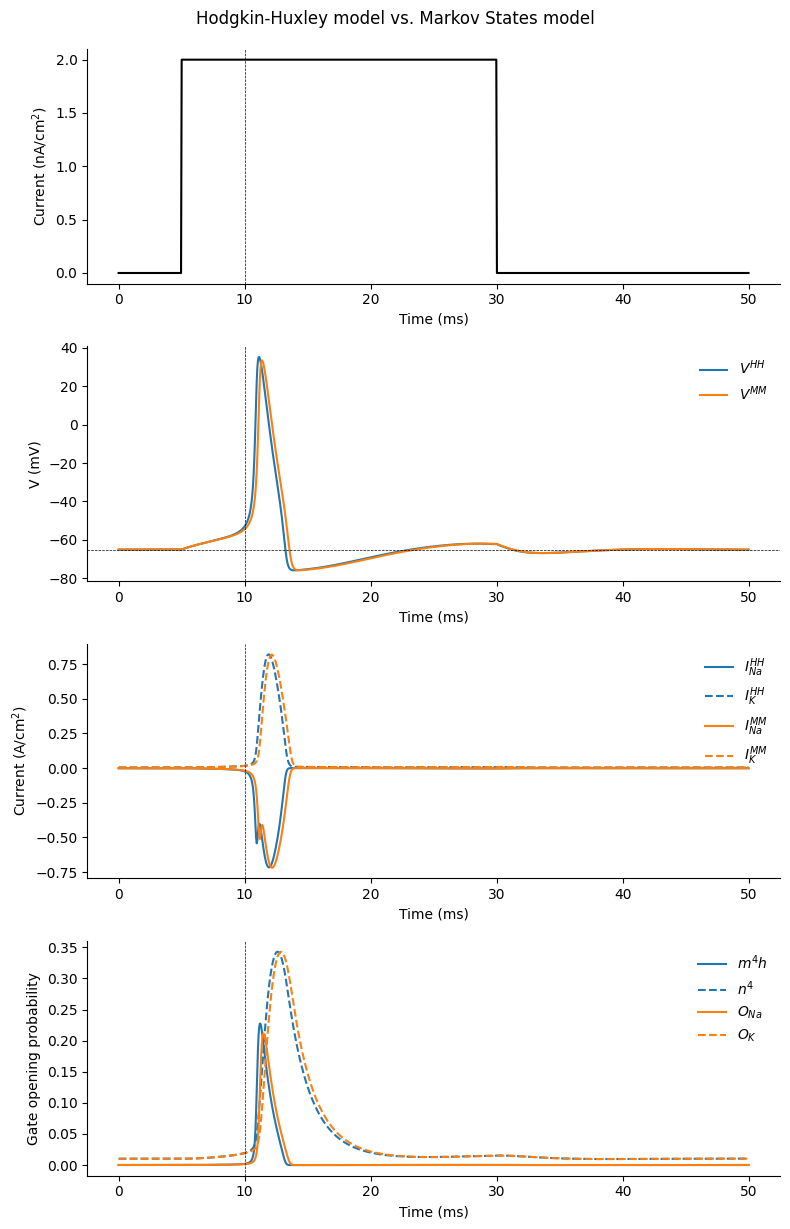

In [4]:
# compare the two models
fig, ax = plt.subplot_mosaic(
    mosaic=[["I"], ["V"], ["i"], ["O"]], 
    figsize=(8, 12)
)

ax["I"].plot(time_vec, current * 1000, color='black')
ax["I"].set_ylabel("Current (nA/cm$^2$)")

ax["V"].plot(time_vec, s_hh_dict["v"], label=r"$V^{HH}$")
ax["V"].plot(time_vec, s_mm_dict["v"], label=r"$V^{MM}$")
ax["V"].axhline(-65, color="black", lw=0.5, ls="--")
ax["V"].set_ylabel("V (mV)")
ax["V"].legend(frameon=False)

ax["i"].plot(time_vec, s_hh_dict["i_Na"] / 1000, label=r"$I_{Na}^{HH}$", color="C0") 
ax["i"].plot(time_vec, s_hh_dict["i_K"] / 1000, label=r"$I_{K}^{HH}$", color="C0", linestyle='--', ) 

ax["i"].plot(time_vec, s_mm_dict["i_Na"] / 1000, label=r"$I_{Na}^{MM}$", color="C1" ) 
ax["i"].plot(time_vec, s_mm_dict["i_K"] / 1000, color="C1", linestyle='--', label=r"$I_{K}^{MM}$") 
ax["i"].set_ylabel("Current (A/cm$^2$)")
ax["i"].legend(frameon=False)

ax["O"].plot(time_vec, s_hh_dict["Na_m"] ** 3 * s_hh_dict["Na_h"], label=r"$m^4h$", color="C0")
ax["O"].plot(time_vec, s_hh_dict["K_n"] ** 4, label=r"$n^4$",  color="C0", linestyle='--')

ax["O"].plot(time_vec, s_mm_dict["Na_O"], label=r"$O_{Na}$",color="C1")
ax["O"].plot(time_vec, s_mm_dict["K_O"], label=r"$O_{K}$", color="C1", linestyle='--')
ax["O"].set_ylabel("Gate opening probability")
ax["O"].legend(frameon=False)

for a in ax.values():
    a.spines[["top", "right"]].set_visible(False)
    a.axvline(10, color="black", lw=0.5, ls="--")
    a.set_xlabel("Time (ms)")

fig.tight_layout()
fig.suptitle("Hodgkin-Huxley model vs. Markov States model", y=1.02)

In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-09-17 15:11:59CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.2.1

jax       : 0.4.30
matplotlib: 3.8.3
jaxley    : 0.2.1

Watermark: 2.4.3

